# Edge Detection by Zero-crossing


### Problem Statement.

We have learnt that Zero Crossing of 2nd Derivative strongly represent edges in an image. The task assigned to us in this problem is to compute the edges in an image using two different approaches:
    1. Difference of Gaussian (DoG)
    2. Laplacian of Gaussian (LoG)

Let us explore each method in detail, while solving each sub-task in the presented problem.

## 1. Difference of Gaussian (DoG)

In Difference of Gaussians(DoG) approach for edge detection, the given image is smoothed using a Gaussian kernel of certain width sigma1.

With a different Gaussian Kernel of width sigma2, another Gaussian smoothed representation of original image is obtained.

The difference of such two Gaussian smoothed images can be used for detecting edges in our original image, and is called as the __Difference of Gaussian (DoG).__

***As the difference between two differently low-pass filtered images, the DoG is actually a band-pass filter, which removes high frequency components representing noise, and also some low frequency components representing the homogeneous areas in the image. The frequency components in the passing band are assumed to be associated to the edges in the images.***

After applying the DoG kernel to our original image, the edges in the image can be obtained by performing the following steps:
    1. Apply DoG kernel to original image by convolution.
    2. Detect Zero-Crossings in the resultant image obtained from above step.
    3. Threshold the Zero Crossings to keep only the strong edges, and weed out the weak edges.The weak edges may be generated by the noise, and they need to be eliminated.
    
With this approach, let us follow the procedure step by step, and view the results.

First let us import all the necessary python packages.

In [184]:
% matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math

Now let us define some basic helper functions which will be essential in our solution going forward. These functions are useful for visualising the plots/graphs and also resizing images of different sizes to same size.

In [185]:
# Functions to plot our results
def plot_input(img, title):
    plt.imshow(img, cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    
def handle_img_padding(img1, img2):
    M1, N1 = img1.shape[:2]
    M2, N2 = img2.shape[:2]
    padding_x = np.abs(M2 - M1)/2
    padding_y = np.abs(N2 - N1)/2
    img2 = img2[padding_x:M1+padding_x, padding_y: N1+padding_y]
    return img2

As the first step to our solution, let us import/read the provided image, the edges in which we have to detect for this problem. 
We have used OpenCV to read the image and have plotted the image as an 8-bit grayscale image below.

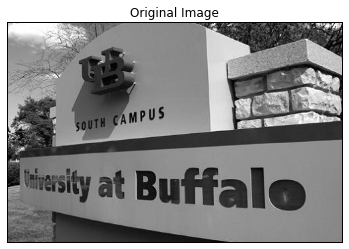

In [186]:
original_img = cv2.imread('./UBCampus.jpg', 0)
plot_input(original_img, 'Original Image')

### Part A. 
In this section, we shall start by defining the provided Difference of Gaussian(DoG) kernel in Python. Next we shall convolute the kernel with our given image, and display the resultant image ie. DoG image.

In [187]:
DoG_kernel = [
            [0,   0, -1, -1, -1, 0, 0],
            [0,  -2, -3, -3, -3,-2, 0],
            [-1, -3,  5,  5,  5,-3,-1],
            [-1, -3,  5, 16,  5,-3,-1],
            [-1, -3,  5,  5,  5,-3,-1],
            [0,  -2, -3, -3, -3,-2, 0],
            [0,   0, -1, -1, -1, 0, 0]
        ]

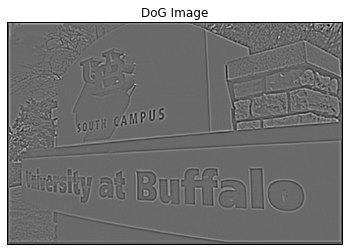

In [188]:
dog_img = convolve2d(original_img, DoG_kernel)
plot_input(dog_img, 'DoG Image')

We can see the result of applying the DoG mask to our original image, as seen above. As we can note, the DoG kernel seems to have smoothened the image, and acted as a bandpass filter to remove high and low frequency data.
Next, we shall perform Zero-Crossing on the above result.

### Part B.

In this section, we shall compute and display the zero-crossing of the DoG image.

We perform a 8 neighbour zero crossing, which implies that we shall mark the current pixel as 1, if the sign of intensity value corresponding to any of the 8 neighbors of current pixel is opposite of the sign of current pixel. 

We shall iterate over each pixel in the image and mark all such zero crossings.

In [193]:
def zero_cross_detection(image):
    z_c_image = np.zeros(image.shape)

    for i in range(0,image.shape[0]-1):
        for j in range(0,image.shape[1]-1):
            if image[i][j]>0:
                if image[i+1][j] < 0 or image[i+1][j+1] < 0 or image[i][j+1] < 0:
                    z_c_image[i,j] = 1
            elif image[i][j] < 0:
                if image[i+1][j] > 0 or image[i+1][j+1] > 0 or image[i][j+1] > 0:
                    z_c_image[i,j] = 1
    return z_c_image

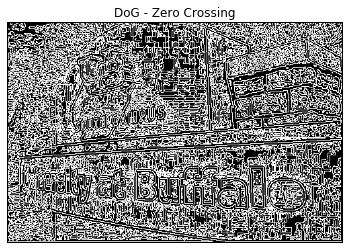

In [195]:
zero_crossing_dog = zero_cross_detection(dog_img)
zero_crossing_dog = handle_img_padding(original_img, zero_crossing_dog)
plot_input(zero_crossing_dog,'DoG - Zero Crossing')

We have plotted the result of zero-crossing of DoG image in the plot above. 

As we can infer, ***there are a lot of weak edges***, generated because of noise in the image, and we need to eliminate all such weak edges, while storing only the ***Strong Edges.***

We shall define the strategy for finding the Strong edges in the next section.

### Part C.

Generally, the first order derivative operators can be used for edge detection in images, but they are very sensitive to noise and produce thicker edges.

2nd Order Derivative operators are more sophisticated methods towards automatized edge detection, however, still very noise-sensitive, as we have seen in the DoG image above.If there is a significant spatial change in the second derivative, an edge is detected.

But combining these two strategies, to increase the confidence of detected edge is often the best practice for edge detection. Hence our strategy is to:
#### Compute the first-order derivative edges as well, and the edges which appear in both the DoG(2nd order) image and 1st order derivative operator shall be our Strong Edges.

We shall use the __Sobel filter__ to detect the first-order derivative edges. We could have use Roberts filter or Prewitt operator as well for first order derivative, but Roberts filter gives no information about edge orientation and works best with binary images, while Prewitt operator is very sensitive to noise.

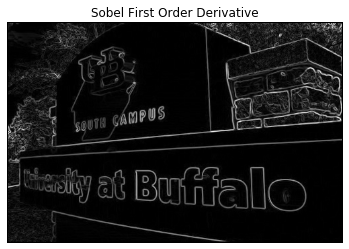

In [48]:
sobelx = cv2.Sobel(original_img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(original_img,cv2.CV_64F,0,1,ksize=3)
sobel_first_derivative = cv2.magnitude(sobelx,sobely)
plot_input(sobel_first_derivative, 'Sobel First Order Derivative')

Above we have plotted the magnitude(sq.root of Gx^2 + Gy^2) image of first-order derivative, obtained by applying Sobel filter on our original image.

We can boost the edges in the first-order Sobel operator above, by thresholding. For finding the optimum threshold, we shall plot the histogram of pixel intensities in Sobel filter result, and make a manual judgement. 

The procedure is seen in steps below, where we have chosen our threshold as 200.

/Library/Python/2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 329 x 500)
  '(shape is %d x %d)' % inp.shape[::-1])


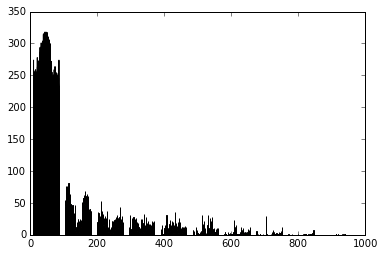

In [51]:
plt.hist(sobel_first_derivative)
plt.show()

In [167]:
sobel_test = np.empty_like (sobel_first_derivative)
sobel_test[:] = sobel_first_derivative

In [168]:
sobel_test[sobel_test > 200] = 255
sobel_test[sobel_test < 200] = 0

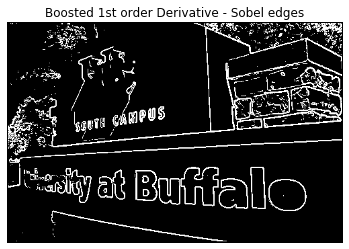

In [203]:
plot_input(sobel_test,'Boosted 1st order Derivative - Sobel edges')

Above we have plotted the thresholded Sobel-filter edges. The edges look much more bright, but as stated earlier they are thicker.

Let us now eliminate the weak edges in our DoG image, and only consider the strong edges. This is done by preserving the edges observed in both DoG and Sobel operated edges, and eliminating all other weak edges in DoG. We shall do a logical 'AND' of both the images, so that the result is just composed of the STRONG EDGES.

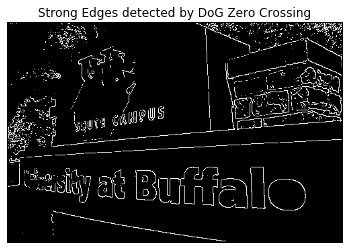

In [204]:
plot_input(cv2.bitwise_and(zero_crossing_dog,sobel_test), 'Strong Edges detected by DoG Zero Crossing')

This is the result of our __Edge Detection using DoG and Zero Crossing.__

Now let us proceed with the second part of the problem, where we use another approach for solving the same problem.

## 2. Laplacian of Gaussian (LoG)

As we know, the Laplace operator can be used to detect edges, but it can detect noise as well. Hence we can apply Gaussian smooting on a given image to eliminate the noise, before we apply Laplace operator to detect edges, and suppress noise detection.

As we know, convolution is associative in nature, we can first convolve the Gaussian filter and the Laplace operator, and then apply this resulting mask on our given image, to detect edge.

The filter applied by convolving the Laplace operator and the Gaussian, is called the __Laplacian of Gaussian filter.__ 


The edge detection procedure is very similar to our DoG approach, and is stated below:
    1. Apply the Laplacian of Gaussian(LoG) kernel to our original image. 
    2. Detect Zero-Crossings in the resultant image obtained from above step.
    3. Threshold the Zero Crossings to keep only the strong edges, and weed out the weak edges.The weak edges may be generated by the noise, and they need to be eliminated.

### Part D.

Let us begin by defining the LoG kernel. Next, we shall plot the original image, so that we have a reference point, to view the edge detection procedure by LoG. 

In [197]:
LoG_kernel = np.array([
                        [0, 0,  1, 0, 0],
                        [0, 1,  2, 1, 0],
                        [1, 2,-16, 2, 1],
                        [0, 1,  2, 1, 0],
                        [0, 0,  1, 0, 0]
                    ])

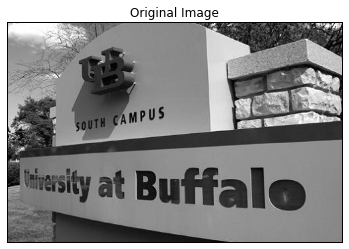

In [198]:
original_img = cv2.imread('./UBCampus.jpg', 0)
plot_input(original_img, 'Original Image')

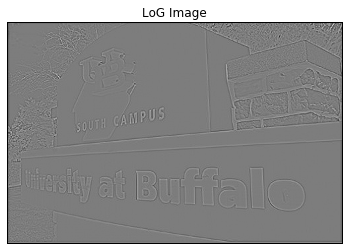

In [173]:
log_img = convolve2d(original_img, LoG_kernel)
plot_input(log_img, 'LoG Image')

Above we can see the __resultant Laplacian of Gaussian(LoG) image__, obtained after applying the LoG filter to our input image.

Next, we shall follow the same procedure to detect the Zero-Crossings in the LoG image obtained above.

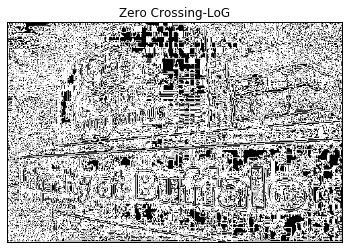

In [201]:
zero_crossing_log = zero_cross_detection(log_img)
zero_crossing_log = handle_img_padding(original_img, zero_crossing_log)
plot_input(zero_crossing_log,'Zero Crossing-LoG')

Above we have plotted the resultant image after performing Zero Crossing on the LoG image. As we can see, the image has even more weak edges than in case of DoG, and we need to eliminate these weak edges and store only the Strong edges as our edge detection output.

We already have computed the Sobel filter output, which represent the 1st-order derivative edges in our original image. We shall perform a __logical AND of the two images(LoG and Sobel output)__ which shall give us our resultant strong edges.

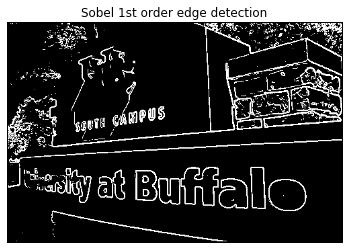

In [205]:
plot_input(sobel_test, 'Sobel 1st order edge detection')

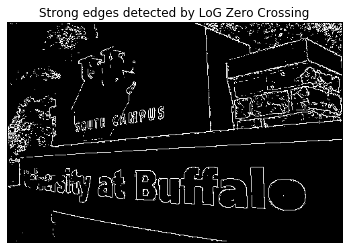

In [206]:
plot_input(cv2.bitwise_and(zero_crossing_log,sobel_test), 'Strong edges detected by LoG Zero Crossing')

#### This is the result of LoG zero-crossing edges by applying the given LoG mask to the test image provided.

### Part E.

The Difference of Gaussians (DoG) is a second-derivative operator which is often used to estimate the Laplacian of Gaussian operator. 

As we have seen previously, DoG is calculated by taking the difference of two multinormal distributions with σ1 and σ2. The different widths, create a band-pass filter which approximates the Mexican Hat function. The exact values of sizes of the two kernels that are used to approximate the Laplacian of Gaussian will determine the scale of the difference image, which may appear blurry as a result.
Usually a ratio of σ1 to σ2 ~ 1.6 is said to best approximate the 2nd derivative Laplacian of Gaussian function. In theory, the smaller the ratio between two sigmas, the better the approximation. 

In practice, while approximating LoG we get numerical errors at some point(because of approximations) and as a result both the __outputs are not exactly the same.__

The benefit of approximating LoG by DoG is that, we can calculate LoG approximations for a range of sigmas, by storing the Gaussian functions at different σ, and experiment on the best difference suited to our task. This approach also reduces the computational cost involved in experimenting across different LoG kernels.